In [1]:
import numpy as np
import pandas as pd
from typing import Dict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from surprise import SVD, Dataset, Reader
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline 
sns.set(style="ticks")

In [2]:
df=pd.read_csv('books.csv')

In [3]:
df.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [4]:
df.shape

(10000, 23)

In [5]:
rating=pd.read_csv('ratings.csv')

In [6]:
rating.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [7]:
rating.shape

(981756, 3)

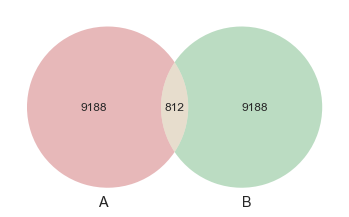

In [8]:
venn2([set(rating['book_id'].unique()), set(df['book_id'].unique())])

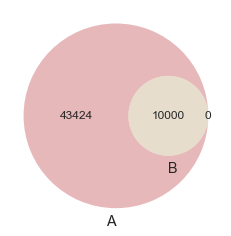

In [9]:
venn2([set(rating['user_id'].unique()), set(df['id'].unique())])

In [10]:
book_ids=rating[rating['book_id'].notnull()]['book_id']
df_book = df[df['book_id'].isin(book_ids)]

In [11]:
df.shape,df_book.shape

((10000, 23), (812, 23))

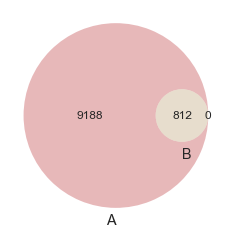

In [12]:
venn2([set(rating['book_id'].unique()), set(df_book['book_id'].unique())])

In [13]:
df_book_author = df_book[df_book['authors'].notnull()]
df_book_author = df_book_author[~df_book_author['authors'].str.isspace()]

In [14]:
book_id=df_book_author['book_id'].values
book_id[0:5]

array([   3, 2657, 4671, 5907, 5107], dtype=int64)

In [15]:
book_name=df_book_author['original_title'].values
book_name[0:5]

array(["Harry Potter and the Philosopher's Stone",
       'To Kill a Mockingbird', 'The Great Gatsby',
       'The Hobbit or There and Back Again', 'The Catcher in the Rye'],
      dtype=object)

In [16]:
author=df_book_author['authors'].values
author[0:5]

array(['J.K. Rowling, Mary GrandPré', 'Harper Lee', 'F. Scott Fitzgerald',
       'J.R.R. Tolkien', 'J.D. Salinger'], dtype=object)

In [17]:
language=df_book_author['language_code'].values
language[0:5]

array(['eng', 'eng', 'eng', 'en-US', 'eng'], dtype=object)

In [18]:
%%time
tfidfv = TfidfVectorizer()
author_matrix = tfidfv.fit_transform(author)
author_matrix

CPU times: total: 15.6 ms
Wall time: 12 ms


<812x1020 sparse matrix of type '<class 'numpy.float64'>'
	with 2313 stored elements in Compressed Sparse Row format>

In [19]:
class SimpleKNNRecommender:
    
    def __init__(self, X_matrix, X_ids, X_name, X_author, X_language):

        self._X_matrix = X_matrix
        self.df = pd.DataFrame(
            {'id': pd.Series(X_ids, dtype='int'),
            'name': pd.Series(X_name, dtype='str'),
            'author': pd.Series(X_author, dtype='str'),
            'language':pd.Series(X_language,dtype='str'),
            'dist': pd.Series([], dtype='float')})
            
            
    def recommend_for_single_object(self, K: int, \
                X_matrix_object, cos_flag = True, manh_flag = False):
        """
        Метод формирования рекомендаций для одного объекта.
        Входные параметры:
        K - количество рекомендуемых соседей 
        X_matrix_object - строка матрицы объект-признак, соответствующая объекту
        cos_flag - флаг вычисления косинусного расстояния
        manh_flag - флаг вычисления манхэттэнского расстояния
        Возвращаемое значение: K найденных соседей
        """
        
        scale = 1000000
        # Вычисляем косинусную близость
        if cos_flag:
            dist = cosine_similarity(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=False)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] < scale]
        
        else:
            if manh_flag:
                dist = manhattan_distances(self._X_matrix, X_matrix_object)
            else:
                dist = euclidean_distances(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=True)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] > 0.0]            
        
        # Оставляем К первых рекомендаций
        res = res.head(K)
        return res

In [20]:
Harry_Potter=0
book_name[Harry_Potter]

"Harry Potter and the Philosopher's Stone"

In [21]:
author[Harry_Potter]

'J.K. Rowling, Mary GrandPré'

In [22]:
Harry_Potter_matrix=author_matrix[Harry_Potter]
Harry_Potter_matrix

<1x1020 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [23]:
skr1 = SimpleKNNRecommender(author_matrix, book_id, book_name, author, language)
rec1 = skr1.recommend_for_single_object(15,Harry_Potter_matrix)
rec1

,id,name,author,language,dist
9,5,Harry Potter and the Prisoner of Azkaban,"J.K. Rowling, Mary GrandPré, Rufus Beck",eng,698734.891897
773,2002,NaN,J.K. Rowling,eng,568566.112224
505,10,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling,eng,568566.112224
726,8646,Crow Lake,Mary Lawson,eng,351175.639858
510,5182,Songs in Ordinary Time,Mary McGarry Morris,eng,276036.886797
535,1426,Manual do guerreiro da luz,Paulo Coelho,en-US,0.000000
536,6572,Suffer the Children,John Saul,en-US,0.000000
537,36,The Lord of the Rings: Weapons and Warfare,"Chris Smith, Christopher Lee, Richard Taylor",eng,0.000000
538,7194,El club Dumas,"Arturo Pérez-Reverte, Sonia Soto",eng,0.000000
539,3378,Generation X: Tales for an Accelerated Culture,Douglas Coupland,eng,0.000000


In [24]:
rec2 = skr1.recommend_for_single_object(15, Harry_Potter_matrix, cos_flag = False)
rec2

,id,name,author,language,dist
9,5,Harry Potter and the Prisoner of Azkaban,"J.K. Rowling, Mary GrandPré, Rufus Beck",eng,7.762282e+05
505,10,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling,eng,9.289068e+05
773,2002,NaN,J.K. Rowling,eng,9.289068e+05
726,8646,Crow Lake,Mary Lawson,eng,1.139144e+06
510,5182,Songs in Ordinary Time,Mary McGarry Morris,eng,1.203298e+06
467,4035,The Burden of Proof,Scott Turow,eng,1.414214e+06
493,6462,His Excellency: George Washington,Joseph J. Ellis,eng,1.414214e+06
462,6862,Amsterdam,Ian McEwan,NaN,1.414214e+06
496,415,Gravity's Rainbow,Thomas Pynchon,eng,1.414214e+06
497,3686,Truth & Beauty: A Friendship,Ann Patchett,eng,1.414214e+06


In [25]:
rec3 = skr1.recommend_for_single_object(15, Harry_Potter_matrix, 
                                        cos_flag = False, manh_flag = True)
rec3

,id,name,author,language,dist
9,5,Harry Potter and the Prisoner of Azkaban,"J.K. Rowling, Mary GrandPré, Rufus Beck",eng,1.533390e+06
773,2002,NaN,J.K. Rowling,eng,1.594529e+06
505,10,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling,eng,1.594529e+06
726,8646,Crow Lake,Mary Lawson,eng,1.998633e+06
510,5182,Songs in Ordinary Time,Mary McGarry Morris,eng,2.482525e+06
441,4538,The View from Saturday,E.L. Konigsburg,NaN,2.731662e+06
352,3102,Howards End,E.M. Forster,eng,2.731662e+06
304,6192,Disgrace,J.M. Coetzee,eng,2.731662e+06
234,3579,The Complete Anne of Green Gables Boxed Set,L.M. Montgomery,NaN,2.731662e+06
211,3087,A Room with a View,E.M. Forster,eng,2.731662e+06


In [26]:
len(rating['user_id'].unique())

53424

In [27]:
len(rating['book_id'].unique())

10000

In [28]:
def create_utility_matrix(data):
    itemField = 'book_id'
    userField = 'user_id'
    valueField = 'rating'  
    
    userList = data[userField].tolist()
    itemList = data[itemField].tolist()
    valueList = data[valueField].tolist()    
    
    users = list(set(userList))
    items = list(set(itemList))    
    
    users_index = {users[i]: i for i in range(len(users))}    
    pd_dict = {item: [0.0 for i in range(len(users))] for item in items}    
    
    for i in range(0,data.shape[0]):
        item = itemList[i]
        user = userList[i]
        value = valueList[i]    
        pd_dict[item][users_index[user]] = value    
    
    X = pd.DataFrame(pd_dict)
    X.index = users
        
    itemcols = list(X.columns)
    items_index = {itemcols[i]: i for i in range(len(itemcols))}
    
    return X, users_index, items_index

In [29]:
%%time
user_item_matrix, users_index, items_index = create_utility_matrix(rating)

CPU times: total: 1min 42s
Wall time: 1min 52s


In [30]:
user_item_matrix

,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
print(rating.loc[rating['book_id']==3,['user_id','rating']])

     user_id  rating
200      314       3
201      588       1
202     2077       2
203     2487       3
204     2900       3
..       ...     ...
295    50133       5
296    51166       3
297    51460       2
298    52036       1
299    53292       5

[100 rows x 2 columns]


In [32]:
user_item_matrix__test = user_item_matrix.loc[[50133]]
user_item_matrix__test

,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
50133,0.0,5.0,5.0,0.0,0.0,5.0,0.0,5.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
user_item_matrix__train = user_item_matrix.loc[:53424]
user_item_matrix__train

,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
user_item_matrix__train = user_item_matrix.loc[:1000]
user_item_matrix__train

,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
%%time
U, S, VT = np.linalg.svd(user_item_matrix__train.T)
V = VT.T

CPU times: total: 25.8 s
Wall time: 7.09 s


In [36]:
U.shape

(10000, 10000)

In [37]:
V.shape

(1000, 1000)

In [38]:
S.shape

(1000,)

In [39]:
Sigma = np.diag(S)
Sigma.shape

(1000, 1000)

In [40]:
Sigma

array([[6.78501113e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.70177294e+01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.25771171e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.75272997e-15, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.53386923e-15, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.66993463e-16]])

In [41]:
r=3
Ur = U[:, :r]
Sr = Sigma[:r, :r]
Vr = V[:, :r]

In [42]:
test_user = np.mat(user_item_matrix__test.values)
test_user.shape, test_user

((1, 10000), matrix([[0., 5., 5., ..., 0., 0., 0.]]))

In [43]:
tmp = test_user * Ur * np.linalg.inv(Sr)
tmp

matrix([[0.19423073, 0.04758859, 0.1318399 ]])

In [44]:
test_user_result = np.array([tmp[0,0], tmp[0,1], tmp[0,2]])
test_user_result

array([0.19423073, 0.04758859, 0.1318399 ])

In [45]:
cos_sim = cosine_similarity(Vr, test_user_result.reshape(1, -1))
cos_sim[:10]

array([[ 0.47798051],
       [-0.15897535],
       [-0.2281112 ],
       [-0.08105948],
       [ 0.0397638 ],
       [-0.28908537],
       [-0.14303609],
       [-0.18656092],
       [-0.16023771],
       [-0.07543555]])

In [46]:
cos_sim_list = cos_sim.reshape(-1, cos_sim.shape[0])[0]
cos_sim_list[:10]

array([ 0.47798051, -0.15897535, -0.2281112 , -0.08105948,  0.0397638 ,
       -0.28908537, -0.14303609, -0.18656092, -0.16023771, -0.07543555])

In [47]:
recommended_user_id = np.argsort(-cos_sim_list)[0]
recommended_user_id

438

In [48]:
book_list = list(user_item_matrix.columns)
def book_recommend(ind):
    try:
        book_id = book_list[ind]
        flt_rating = rating[rating['book_id'] == book_id]
        rating = flt_rating['book_id'].values[0]
        book_rating = df_book[df_book['book_id'] == rating]
        res = book_rating['original_title'].values[0]
        return res
    except:
        return '' 

In [51]:
i=1
for idx, item in enumerate(np.ndarray.flatten(np.array(test_user))):
    if item > 0:
        book_name = book_recommend(idx)
        print('{} - {}'.format(idx, item))
        if i==20:
            break
        else:
            i+=1

1 - 5.0
2 - 5.0
5 - 5.0
7 - 5.0
9 - 5.0
10 - 5.0
11 - 5.0
12 - 5.0
13 - 5.0
14 - 5.0
15 - 5.0
18 - 5.0
29 - 5.0
32 - 5.0
33 - 5.0
34 - 5.0
35 - 5.0
38 - 5.0
39 - 5.0
42 - 5.0


In [52]:
i=1
recommended_user_item_matrix = user_item_matrix.loc[[recommended_user_id+1]]
for idx, item in enumerate(np.ndarray.flatten(np.array(recommended_user_item_matrix))):
    if item > 0:
        book_name = book_recommend(idx)
        print('{} - {}'.format(idx, item))
        if i==20:
            break
        else:
            i+=1

0 - 3.0
3 - 5.0
6 - 3.0
8 - 3.0
10 - 4.0
16 - 5.0
17 - 4.0
19 - 5.0
21 - 3.0
22 - 2.0
26 - 5.0
30 - 4.0
32 - 3.0
34 - 3.0
37 - 4.0
39 - 1.0
44 - 3.0
45 - 4.0
62 - 3.0
63 - 3.0
